# Grid generation

Generate More Valid Grids (The Design Space)
* Refinement: Grid generation is optional but highly effective. You don't have to rely solely on the original 500,000 grids. If you find a structural pattern that scores high (e.g., a specific mix of zones), you can generate millions of permutations of that pattern to massively expand your pool of valid grids.
* Key Action: Use your top-scoring valid grids to inform a generative model or a guided random search that creates new, highly-scoring grid configurations. This helps find unique, diverse grids that may not exist in the original dataset.


In [62]:
# 🏗️ ADVANCED GRID GENERATION SYSTEM
print("🏗️ Building Advanced Grid Generation System")
print("=" * 50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter, defaultdict
import random
from itertools import combinations, permutations
import warnings
warnings.filterwarnings('ignore')

# Load Oracle predictions and top grids from previous notebooks
print("📂 Loading Oracle predictions and best grids...")

try:
    # Load Oracle predictions
    predictions = np.load('data/submissions/20251028_012622_oracle_predictions_full.npy')
    print(f"✅ Loaded Oracle predictions: {predictions.shape}")
    
    # Load grid data
    grid_files = ['2155-Challenge-Problem-2/datasets/grids_0.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_1.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_2.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_3.npy', 
                 '2155-Challenge-Problem-2/datasets/grids_4.npy']
    
    grid_data_chunks = []
    for file in grid_files:
        grids_chunk = np.load(file)
        grid_data_chunks.append(grids_chunk)
        print(f"   📁 Loaded {file}: {grids_chunk.shape}")
    
    grids = np.vstack(grid_data_chunks)
    print(f"✅ Combined grid data: {grids.shape}")
    
    # Calculate minimum scores
    min_scores = np.min(predictions, axis=1)
    advisor_names = ['Wellness', 'Tax', 'Transportation', 'Business']
    
    print(f"📊 Data Summary:")
    print(f"   Total grids: {len(grids):,}")
    print(f"   Predictions shape: {predictions.shape}")
    print(f"   Min score range: {np.min(min_scores):.4f} - {np.max(min_scores):.4f}")
    
    # Find the best performing grids from existing dataset
    top_threshold = 0.75  # Start with basic validity
    valid_mask = min_scores >= top_threshold
    n_valid = np.sum(valid_mask)
    
    print(f"\n🎯 Current Valid Grids Analysis:")
    print(f"   Grids passing {top_threshold}: {n_valid:,} ({n_valid/len(grids)*100:.3f}%)")
    
    if n_valid > 0:
        best_indices = np.where(valid_mask)[0]
        best_grids = grids[best_indices]
        best_predictions = predictions[best_indices]
        best_min_scores = min_scores[best_indices]
        
        print(f"   Best min score: {np.max(best_min_scores):.4f}")
        print(f"   Best grid index: {best_indices[np.argmax(best_min_scores)]}")
    else:
        print("   ⚠️ No grids pass the 0.75 threshold!")
        # Use top scoring grids instead
        n_top = 1000
        best_indices = np.argsort(min_scores)[-n_top:]
        best_grids = grids[best_indices]
        best_predictions = predictions[best_indices]
        best_min_scores = min_scores[best_indices]
        print(f"   Using top {n_top} scoring grids instead")
        print(f"   Top min score: {np.max(best_min_scores):.4f}")

except Exception as e:
    print(f"❌ Error loading data: {e}")
    print("💡 Creating synthetic example for demonstration...")
    
    # Create synthetic data for demonstration
    np.random.seed(42)
    grids = np.random.randint(0, 5, (10000, 7, 7))
    predictions = np.random.beta(2, 1, (10000, 4)) * 0.4 + 0.5
    min_scores = np.min(predictions, axis=1)
    
    best_indices = np.argsort(min_scores)[-100:]
    best_grids = grids[best_indices]
    best_predictions = predictions[best_indices]
    best_min_scores = min_scores[best_indices]
    
    print(f"📊 Synthetic data created for demonstration")

print(f"\n✅ Setup complete! Ready for grid generation...")
print(f"🎯 Goal: Generate new grids with higher probability of validity")
print(f"📈 Strategy: Learn patterns from best existing grids")

🏗️ Building Advanced Grid Generation System
📂 Loading Oracle predictions and best grids...
✅ Loaded Oracle predictions: (500000, 4)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_0.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_1.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_2.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_3.npy: (100000, 7, 7)
   📁 Loaded 2155-Challenge-Problem-2/datasets/grids_4.npy: (100000, 7, 7)
✅ Combined grid data: (500000, 7, 7)
📊 Data Summary:
   Total grids: 500,000
   Predictions shape: (500000, 4)
   Min score range: -0.2058 - 0.9877

🎯 Current Valid Grids Analysis:
   Grids passing 0.75: 647 (0.129%)
   Best min score: 0.9877
   Best grid index: 440648

✅ Setup complete! Ready for grid generation...
🎯 Goal: Generate new grids with higher probability of validity
📈 Strategy: Learn patterns from best existing grids


In [63]:
# 🧬 GENETIC ALGORITHM GRID GENERATION SYSTEM
print("🧬 Genetic Algorithm Grid Generation System")
print("=" * 50)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import random
import warnings
warnings.filterwarnings('ignore')

class GeneticGridGenerator:
    """Genetic algorithm for generating diverse, high-scoring grids"""
    
    def __init__(self, seed_grids, seed_predictions, oracle_predictor=None):
        self.seed_grids = seed_grids
        self.seed_predictions = seed_predictions
        self.oracle_predictor = oracle_predictor
        self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
        self.best_grids_history = []
        
    def select_high_scoring_parents(self, top_k=200, diversity_threshold=0.3):
        """Select high-scoring diverse grids as initial population"""
        print(f"🎯 Selecting top {top_k} high-scoring diverse grids as parents...")
        
        # Calculate minimum scores
        min_scores = np.min(self.seed_predictions, axis=1)
        
        # Get top scoring indices
        top_indices = np.argsort(min_scores)[-top_k*3:]  # Get more candidates first
        top_grids = self.seed_grids[top_indices]
        top_scores = min_scores[top_indices]
        
        # Select diverse high-scoring grids
        selected_grids = []
        selected_scores = []
        selected_indices = []
        
        # Always include the absolute best
        best_idx = np.argmax(top_scores)
        selected_grids.append(top_grids[best_idx])
        selected_scores.append(top_scores[best_idx])
        selected_indices.append(top_indices[best_idx])
        
        # Select remaining grids based on diversity
        for i in range(len(top_grids)):
            if len(selected_grids) >= top_k:
                break
                
            candidate_grid = top_grids[i]
            candidate_score = top_scores[i]
            
            # Check diversity against already selected grids
            is_diverse = True
            for selected_grid in selected_grids:
                # Calculate hamming distance (different positions / total positions)
                diff_positions = np.sum(candidate_grid != selected_grid)
                diversity = diff_positions / 49.0  # 7x7 = 49 total positions
                
                if diversity < diversity_threshold:
                    is_diverse = False
                    break
            
            if is_diverse:
                selected_grids.append(candidate_grid)
                selected_scores.append(candidate_score)
                selected_indices.append(top_indices[i])
        
        selected_grids = np.array(selected_grids)
        selected_scores = np.array(selected_scores)
        
        print(f"✅ Selected {len(selected_grids)} diverse high-scoring parent grids")
        print(f"   Score range: {np.min(selected_scores):.4f} - {np.max(selected_scores):.4f}")
        print(f"   Mean score: {np.mean(selected_scores):.4f}")
        
        return selected_grids, selected_scores, selected_indices
    
    def mutate_grid(self, grid, mutation_rate=0.3, mutation_intensity='high'):
        """Apply mutations to a grid with high degree of change"""
        mutated_grid = grid.copy()
        
        if mutation_intensity == 'high':
            # High mutation: change 20-40% of positions
            n_mutations = np.random.randint(10, 20)  # 20-40% of 49 positions
        elif mutation_intensity == 'medium':
            # Medium mutation: change 10-25% of positions
            n_mutations = np.random.randint(5, 12)
        else:  # 'low'
            # Low mutation: change 5-15% of positions
            n_mutations = np.random.randint(2, 7)
        
        # Apply mutations
        for _ in range(n_mutations):
            i, j = np.random.randint(0, 7, 2)
            
            # Mutation strategies
            mutation_type = np.random.choice(['random_district', 'swap_nearby', 'cluster_expand'])
            
            if mutation_type == 'random_district':
                # Change to completely random district type
                mutated_grid[i, j] = np.random.randint(0, 5)
                
            elif mutation_type == 'swap_nearby':
                # Swap with a nearby position
                di, dj = np.random.choice([-1, 0, 1], 2)
                ni, nj = min(max(i + di, 0), 6), min(max(j + dj, 0), 6)
                mutated_grid[i, j], mutated_grid[ni, nj] = mutated_grid[ni, nj], mutated_grid[i, j]
                
            elif mutation_type == 'cluster_expand':
                # Expand a nearby cluster
                neighbors = []
                for di in [-1, 0, 1]:
                    for dj in [-1, 0, 1]:
                        ni, nj = i + di, j + dj
                        if 0 <= ni < 7 and 0 <= nj < 7 and (ni != i or nj != j):
                            neighbors.append(mutated_grid[ni, nj])
                
                if neighbors:
                    # Change to most common neighbor type
                    from collections import Counter
                    most_common = Counter(neighbors).most_common(1)[0][0]
                    mutated_grid[i, j] = most_common
        
        return mutated_grid
    
    def crossover_grids(self, parent1, parent2, crossover_type='block'):
        """Create offspring through crossover"""
        child1, child2 = parent1.copy(), parent2.copy()
        
        if crossover_type == 'block':
            # Block crossover: exchange rectangular regions
            x1, y1 = np.random.randint(0, 5, 2)  # Top-left corner
            x2, y2 = np.random.randint(x1+1, 7), np.random.randint(y1+1, 7)  # Bottom-right corner
            
            # Swap the blocks
            child1[x1:x2, y1:y2], child2[x1:x2, y1:y2] = parent2[x1:x2, y1:y2].copy(), parent1[x1:x2, y1:y2].copy()
            
        elif crossover_type == 'diagonal':
            # Diagonal crossover
            for i in range(7):
                for j in range(7):
                    if i + j < 7:  # Upper triangle
                        child1[i, j] = parent2[i, j]
                        child2[i, j] = parent1[i, j]
                        
        elif crossover_type == 'checkerboard':
            # Checkerboard pattern
            for i in range(7):
                for j in range(7):
                    if (i + j) % 2 == 0:
                        child1[i, j] = parent2[i, j]
                        child2[i, j] = parent1[i, j]
        
        return child1, child2
    
    def evaluate_diversity(self, population):
        """Calculate diversity score for a population"""
        if len(population) < 2:
            return 0.0
        
        total_diversity = 0
        comparisons = 0
        
        for i in range(len(population)):
            for j in range(i + 1, len(population)):
                diff_positions = np.sum(population[i] != population[j])
                diversity = diff_positions / 49.0
                total_diversity += diversity
                comparisons += 1
        
        return total_diversity / comparisons if comparisons > 0 else 0.0
    
    def fitness_function(self, predictions, diversity_weight=0.2):
        """Combined fitness function: validity + diversity"""
        min_scores = np.min(predictions, axis=1)
        
        # Base fitness is minimum score
        fitness_scores = min_scores.copy()
        
        # Add diversity bonus (this is approximate, full diversity calculation is expensive)
        # We'll add small random bonus to encourage exploration
        diversity_bonus = np.random.normal(0, 0.02, len(fitness_scores))
        fitness_scores += diversity_weight * diversity_bonus
        
        return fitness_scores
    
    def evolve_population(self, population, predictions, generation):
        """Evolve population for one generation"""
        population_size = len(population)
        
        # Calculate fitness
        fitness_scores = self.fitness_function(predictions)
        
        # Selection: tournament selection
        new_population = []
        
        # Keep top 20% as elites
        elite_size = max(1, population_size // 5)
        elite_indices = np.argsort(fitness_scores)[-elite_size:]
        for idx in elite_indices:
            new_population.append(population[idx])
        
        # Generate rest through crossover and mutation
        while len(new_population) < population_size:
            # Tournament selection for parents
            tournament_size = 3
            parent1_idx = max(np.random.choice(len(population), tournament_size), 
                             key=lambda x: fitness_scores[x])
            parent2_idx = max(np.random.choice(len(population), tournament_size), 
                             key=lambda x: fitness_scores[x])
            
            parent1 = population[parent1_idx]
            parent2 = population[parent2_idx]
            
            # Crossover
            if np.random.random() < 0.7:  # 70% crossover rate
                crossover_type = np.random.choice(['block', 'diagonal', 'checkerboard'])
                child1, child2 = self.crossover_grids(parent1, parent2, crossover_type)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            
            # Mutation
            mutation_intensity = 'high' if generation < 5 else 'medium'  # High mutation early
            
            if np.random.random() < 0.8:  # 80% mutation rate
                child1 = self.mutate_grid(child1, mutation_intensity=mutation_intensity)
            if np.random.random() < 0.8:
                child2 = self.mutate_grid(child2, mutation_intensity=mutation_intensity)
            
            new_population.extend([child1, child2])
        
        # Trim to exact population size
        return np.array(new_population[:population_size])
    
    def run_genetic_algorithm(self, population_size=300, generations=15, 
                            diversity_selection=True):
        """Run the complete genetic algorithm"""
        print(f"\n🧬 Running Genetic Algorithm:")
        print(f"   Population size: {population_size}")
        print(f"   Generations: {generations}")
        print(f"   Diversity selection: {diversity_selection}")
        
        # Step 1: Select high-scoring diverse parents
        initial_population, initial_scores, _ = self.select_high_scoring_parents(
            top_k=population_size, diversity_threshold=0.2
        )
        
        current_population = initial_population
        generation_stats = []
        
        # Evolution loop
        for generation in range(generations):
            print(f"\n🔄 Generation {generation + 1}/{generations}")
            
            # Evaluate current population using CNN Oracles
            print(f"   🔮 Evaluating population with CNN Oracles...")
            if self.oracle_predictor:
                current_predictions = self.oracle_predictor.predict_all_advisors(current_population)
            else:
                # Fallback: use seed predictions as proxy (shouldn't happen)
                current_predictions = np.random.random((len(current_population), 4)) * 0.3 + 0.5
            
            current_min_scores = np.min(current_predictions, axis=1)
            
            # Calculate diversity
            diversity_score = self.evaluate_diversity(current_population)
            
            # Track statistics
            stats = {
                'generation': generation + 1,
                'best_score': np.max(current_min_scores),
                'mean_score': np.mean(current_min_scores),
                'diversity': diversity_score,
                'valid_count': np.sum(current_min_scores >= 0.75)
            }
            generation_stats.append(stats)
            
            print(f"   📊 Stats: Best={stats['best_score']:.4f}, "
                  f"Mean={stats['mean_score']:.4f}, "
                  f"Diversity={stats['diversity']:.3f}, "
                  f"Valid={stats['valid_count']}")
            
            # Store best grids from this generation
            best_indices = np.argsort(current_min_scores)[-20:]  # Top 20
            self.best_grids_history.extend([
                {
                    'generation': generation + 1,
                    'grid': current_population[idx].copy(),
                    'predictions': current_predictions[idx].copy(),
                    'min_score': current_min_scores[idx]
                }
                for idx in best_indices
            ])
            
            # Early stopping if we find many excellent grids
            if np.sum(current_min_scores >= 0.85) > population_size // 4:
                print(f"   🎉 Early stopping: Found {np.sum(current_min_scores >= 0.85)} excellent grids!")
                break
            
            # Evolve to next generation (except for last generation)
            if generation < generations - 1:
                print(f"   🧬 Evolving to next generation...")
                current_population = self.evolve_population(
                    current_population, current_predictions, generation
                )
        
        # Final evaluation and results
        print(f"\n✅ Genetic Algorithm Complete!")
        
        # Final population evaluation
        final_predictions = self.oracle_predictor.predict_all_advisors(current_population)
        final_min_scores = np.min(final_predictions, axis=1)
        final_diversity = self.evaluate_diversity(current_population)
        
        print(f"📊 Final Population Stats:")
        print(f"   Best score: {np.max(final_min_scores):.4f}")
        print(f"   Mean score: {np.mean(final_min_scores):.4f}")
        print(f"   Diversity: {final_diversity:.3f}")
        print(f"   Valid grids (≥0.75): {np.sum(final_min_scores >= 0.75)}")
        print(f"   High-quality grids (≥0.80): {np.sum(final_min_scores >= 0.80)}")
        print(f"   Excellent grids (≥0.85): {np.sum(final_min_scores >= 0.85)}")
        
        return {
            'final_population': current_population,
            'final_predictions': final_predictions,
            'final_min_scores': final_min_scores,
            'generation_stats': generation_stats,
            'best_grids_history': self.best_grids_history
        }

# Initialize the genetic algorithm system
print(f"🔧 Initializing Genetic Algorithm System...")
print(f"   Available data: {len(grids)} grids, {predictions.shape} predictions")

# We'll initialize this after loading the CNN oracles
genetic_generator = None
print(f"✅ Ready to initialize genetic algorithm after CNN Oracle loading...")

🧬 Genetic Algorithm Grid Generation System
🔧 Initializing Genetic Algorithm System...
   Available data: 500000 grids, (500000, 4) predictions
✅ Ready to initialize genetic algorithm after CNN Oracle loading...


In [64]:
# 🔮 CNN ORACLE LOADING AND INITIALIZATION
print("🔮 Loading CNN Oracle Models for Genetic Algorithm")
print("=" * 55)

import os
import sys
sys.path.append('.')

try:
    # Import CNN oracle classes
    from oracle import CNNTransportationOracle, CNNWellnessOracle, CNNBusinessOracle, CNNTaxOracle
    
    print("✅ Successfully imported CNN Oracle classes")
    
    # Define available oracle classes
    oracle_classes = {
        'Business': CNNBusinessOracle,
        'Wellness': CNNWellnessOracle,
        'Tax': CNNTaxOracle,  # Traditional model for Tax
        'Transportation': CNNTransportationOracle
    }
    
    # Oracle file paths
    oracle_files = {
        'Business': 'data/models/business_oracle_model.pkl',
        'Wellness': 'data/models/wellness_oracle_model.pkl', 
        'Tax': 'data/models/tax_oracle_model.pkl',
        'Transportation': 'data/models/transportation_oracle_model.pkl'
    }
    
    # Load pre-trained models
    loaded_models = {}
    for advisor_name, filename in oracle_files.items():
        if os.path.exists(filename):
            print(f"📁 Loading {advisor_name} Oracle from {filename}...")
            try:
                oracle_class = oracle_classes[advisor_name]
                oracle = oracle_class()
                oracle.load_model(filename)
                
                loaded_models[advisor_name] = oracle
                print(f"✅ {advisor_name} Oracle loaded successfully!")
            except Exception as e:
                print(f"❌ Failed to load {advisor_name} Oracle: {e}")
        else:
            print(f"⚠️  {filename} not found for {advisor_name}")
    
    # Create predictor class for genetic algorithm
    class GeneticOraclePredictor:
        def __init__(self, loaded_models):
            self.loaded_models = loaded_models
            self.advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
            
        def predict_advisor(self, grids, advisor_idx):
            """Predict using pre-trained model for specific advisor"""
            advisor_name = self.advisor_names[advisor_idx]
            
            if advisor_name in self.loaded_models:
                oracle = self.loaded_models[advisor_name]
                return oracle.predict(grids)
            else:
                print(f"⚠️  No model for {advisor_name}, using fallback scores")
                # Return reasonable fallback scores
                return np.random.beta(2, 3, len(grids)) * 0.4 + 0.5
        
        def predict_all_advisors(self, grids):
            """Predict for all advisors - BATCH PROCESSING for efficiency"""
            print(f"   🚀 Evaluating {len(grids)} grids with CNN Oracles...")
            
            predictions = []
            for advisor_idx in range(4):
                advisor_name = self.advisor_names[advisor_idx]
                
                if advisor_name in self.loaded_models:
                    oracle = self.loaded_models[advisor_name]
                    advisor_predictions = oracle.predict(grids)
                    predictions.append(advisor_predictions)
                else:
                    # Fallback scores
                    fallback_scores = np.random.beta(2, 3, len(grids)) * 0.4 + 0.5
                    predictions.append(fallback_scores)
            
            result = np.stack(predictions).T
            print(f"   ✅ Predictions complete: {result.shape}")
            return result
    
    # Initialize the predictor
    oracle_predictor = GeneticOraclePredictor(loaded_models)
    
    print(f"\n📊 Oracle Status Summary:")
    print(f"   Loaded models: {len(loaded_models)}")
    for advisor_name in loaded_models.keys():
        oracle = loaded_models[advisor_name]
        oracle_type = "CNN" if hasattr(oracle, 'model') else "Traditional"
        print(f"   ✓ {advisor_name}: {oracle_type}")
    
    oracle_available = len(loaded_models) > 0
    
    if oracle_available:
        print(f"\n🎯 Ready for genetic algorithm with CNN Oracle evaluation!")
    else:
        print(f"\n⚠️  No Oracle models loaded - genetic algorithm will use fallback scoring")
        
except Exception as e:
    print(f"❌ Error setting up CNN Oracle models: {e}")
    oracle_available = False
    oracle_predictor = None

🔮 Loading CNN Oracle Models for Genetic Algorithm
✅ Successfully imported CNN Oracle classes
📁 Loading Business Oracle from data/models/business_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/business_oracle_model_pytorch.pth
✅ Business Oracle loaded successfully!
📁 Loading Wellness Oracle from data/models/wellness_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/wellness_oracle_model_pytorch.pth
✅ Wellness Oracle loaded successfully!
📁 Loading Tax Oracle from data/models/tax_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/tax_oracle_model_pytorch.pth
✅ Tax Oracle loaded successfully!
📁 Loading Transportation Oracle from data/models/transportation_oracle_model.pkl...
🔥 PyTorch available, using device: cpu
📁 Loaded PyTorch model from data/models/transportation_oracle_model_pytorch.pth
✅ Transportation Oracle loaded successfully!

📊 Orac

In [65]:
# 🚀 RUN GENETIC ALGORITHM FOR GRID GENERATION
print("🚀 Running Genetic Algorithm for Grid Generation")
print("=" * 50)

if oracle_predictor is not None:
    # Initialize genetic algorithm with high-scoring seed grids
    print("🔧 Initializing Genetic Algorithm...")
    genetic_generator = GeneticGridGenerator(
        seed_grids=grids,
        seed_predictions=predictions, 
        oracle_predictor=oracle_predictor
    )
    
    # Run the genetic algorithm
    print(f"🧬 Starting genetic evolution...")
    results = genetic_generator.run_genetic_algorithm(
        population_size=300,  # INCREASED: Larger population for more diversity
        generations=20,       # INCREASED: More generations for better evolution
        diversity_selection=True
    )
    
    # Extract results
    final_population = results['final_population']
    final_predictions = results['final_predictions']
    final_min_scores = results['final_min_scores']
    generation_stats = results['generation_stats']
    best_grids_history = results['best_grids_history']
    
    print(f"\n🎉 GENETIC ALGORITHM RESULTS:")
    print(f"   Final population size: {len(final_population)}")
    print(f"   Best score achieved: {np.max(final_min_scores):.4f}")
    print(f"   Valid grids (≥0.75): {np.sum(final_min_scores >= 0.75)}")
    print(f"   High-quality (≥0.80): {np.sum(final_min_scores >= 0.80)}")
    print(f"   Excellent (≥0.85): {np.sum(final_min_scores >= 0.85)}")
    
    # Select top diverse grids for final output
    print(f"\n🎯 Selecting top diverse grids...")
    
    # Get all grids from history + final population
    all_evolved_grids = []
    all_evolved_predictions = []
    all_evolved_scores = []
    
    # Add grids from history
    for entry in best_grids_history:
        all_evolved_grids.append(entry['grid'])
        all_evolved_predictions.append(entry['predictions'])
        all_evolved_scores.append(entry['min_score'])
    
    # Add final population
    for i in range(len(final_population)):
        all_evolved_grids.append(final_population[i])
        all_evolved_predictions.append(final_predictions[i])
        all_evolved_scores.append(final_min_scores[i])
    
    all_evolved_grids = np.array(all_evolved_grids)
    all_evolved_predictions = np.array(all_evolved_predictions)  
    all_evolved_scores = np.array(all_evolved_scores)
    
    print(f"   Initial evolved grids: {len(all_evolved_grids)}")
    
    # 🔄 ADD ROTATIONS AND REFLECTIONS OF HIGH-SCORING GRIDS
    print(f"\n🔄 Adding rotations and reflections of high-scoring grids...")
    
    def generate_transformations(grid):
        """Generate all unique transformations (rotations + reflections) of a grid"""
        transformations = []
        
        # Original grid
        transformations.append(grid)
        
        # 4 rotations (0°, 90°, 180°, 270°)
        for k in range(1, 4):  # Skip k=0 (original)
            rotated = np.rot90(grid, k)
            transformations.append(rotated)
        
        # Horizontal flip + its rotations
        h_flipped = np.fliplr(grid)
        transformations.append(h_flipped)
        for k in range(1, 4):
            rotated_flipped = np.rot90(h_flipped, k)
            transformations.append(rotated_flipped)
        
        return transformations
    
    # Select high-scoring grids for transformation (top 20% by score)
    high_score_threshold = np.percentile(all_evolved_scores, 80)  # Top 20%
    high_scoring_indices = np.where(all_evolved_scores >= high_score_threshold)[0]
    
    print(f"   High-scoring grids (≥{high_score_threshold:.3f}): {len(high_scoring_indices)}")
    
    # Generate transformations and evaluate them
    expanded_grids = []
    expanded_predictions = []
    expanded_scores = []
    
    # Keep original grids
    expanded_grids.extend(all_evolved_grids.tolist())
    expanded_predictions.extend(all_evolved_predictions.tolist())
    expanded_scores.extend(all_evolved_scores.tolist())
    
    transformation_count = 0
    for idx in high_scoring_indices:
        original_grid = all_evolved_grids[idx]
        
        # Generate all transformations
        transformations = generate_transformations(original_grid)
        
        # Skip the first one (original - already included)
        for transformed_grid in transformations[1:]:
            # Check if this transformation is significantly different from originals
            is_unique = True
            for existing_grid in all_evolved_grids:
                diff_positions = np.sum(transformed_grid != existing_grid)
                similarity = 1.0 - (diff_positions / 49.0)
                
                if similarity > 0.95:  # Very similar to existing grid
                    is_unique = False
                    break
            
            if is_unique:
                expanded_grids.append(transformed_grid)
                transformation_count += 1
    
    print(f"   Added {transformation_count} unique transformations")
    
    # Evaluate the new transformed grids with Oracle
    if transformation_count > 0:
        # Get only the new transformation grids (last transformation_count grids)
        original_count = len(all_evolved_grids)
        new_grids = np.array(expanded_grids[original_count:])  # Only the new transformations
        print(f"   🔮 Evaluating {len(new_grids)} transformed grids with CNN Oracles...")
        
        if oracle_predictor and len(new_grids) > 0:
            new_predictions = oracle_predictor.predict_all_advisors(new_grids)
            new_scores = np.min(new_predictions, axis=1)
            
            # Add to the expanded lists
            expanded_predictions.extend(new_predictions.tolist())
            expanded_scores.extend(new_scores.tolist())
        else:
            # Fallback: use original scores as approximation
            for i in range(len(new_grids)):
                expanded_predictions.append([0.6, 0.6, 0.6, 0.6])  # Conservative scores
                expanded_scores.append(0.6)
    
    # Update the evolved grids with transformations
    all_evolved_grids = np.array(expanded_grids)
    all_evolved_predictions = np.array(expanded_predictions)
    all_evolved_scores = np.array(expanded_scores)
    
    print(f"   ✅ Total evolved grids after transformations: {len(all_evolved_grids)}")
    print(f"   📈 Transformation expansion: +{transformation_count} unique grids")
    print(f"   🎯 New score range: {np.min(all_evolved_scores):.3f} - {np.max(all_evolved_scores):.3f}")
    
    # Select top scoring + diverse grids with STRICT duplicate filtering
    def select_diverse_top_grids(grids, predictions, scores, target_count=500):
        """Select diverse high-scoring grids with strict duplicate filtering"""
        selected_grids = []
        selected_predictions = []
        selected_scores = []
        
        # Sort by score
        sorted_indices = np.argsort(scores)[::-1]
        
        # STRICTER diversity thresholds
        strict_diversity_threshold = 0.02  # Must be >98% different (strict duplicates)
        diversity_threshold = 0.10  # Must be >90% different (near-duplicates)
        
        duplicates_removed = 0
        near_duplicates_removed = 0
        
        for idx in sorted_indices:
            if len(selected_grids) >= target_count:
                break
            
            candidate_grid = grids[idx]
            candidate_pred = predictions[idx]
            candidate_score = scores[idx]
            
            # Check for exact/near duplicates first (strict filter)
            is_duplicate = False
            is_diverse = True
            
            for selected_grid in selected_grids:
                diff_positions = np.sum(candidate_grid != selected_grid)
                diversity = diff_positions / 49.0
                
                # Strict duplicate check (>98% similar)
                if diversity < strict_diversity_threshold:
                    is_duplicate = True
                    duplicates_removed += 1
                    break
                
                # Diversity check (>90% similar)
                if diversity < diversity_threshold:
                    is_diverse = False
                    break
            
            # Skip exact duplicates always
            if is_duplicate:
                continue
            
            # For the top 20 grids, always include (even if not diverse)
            # For others, require diversity
            if len(selected_grids) < 20 or is_diverse:
                selected_grids.append(candidate_grid)
                selected_predictions.append(candidate_pred)
                selected_scores.append(candidate_score)
            else:
                near_duplicates_removed += 1
        
        print(f"   🔧 Duplicate filtering: Removed {duplicates_removed} exact duplicates, {near_duplicates_removed} near-duplicates")
        
        return np.array(selected_grids), np.array(selected_predictions), np.array(selected_scores)
    
    # Select final diverse set
    final_diverse_grids, final_diverse_predictions, final_diverse_scores = select_diverse_top_grids(
        all_evolved_grids, all_evolved_predictions, all_evolved_scores, target_count=2000  # INCREASED: Keep more diverse grids
    )
    
    # 🔍 FINAL DUPLICATE CHECK - Extra safety measure
    print(f"\n🔍 Final duplicate verification...")
    unique_grids = []
    unique_predictions = []
    unique_scores = []
    final_duplicates_found = 0
    
    for i in range(len(final_diverse_grids)):
        candidate_grid = final_diverse_grids[i]
        is_unique = True
        
        # Check against already verified unique grids
        for unique_grid in unique_grids:
            if np.array_equal(candidate_grid, unique_grid):
                is_unique = False
                final_duplicates_found += 1
                break
        
        if is_unique:
            unique_grids.append(candidate_grid)
            unique_predictions.append(final_diverse_predictions[i])
            unique_scores.append(final_diverse_scores[i])
    
    # Update with truly unique grids
    final_diverse_grids = np.array(unique_grids)
    final_diverse_predictions = np.array(unique_predictions)
    final_diverse_scores = np.array(unique_scores)
    
    print(f"   ✅ Found and removed {final_duplicates_found} remaining exact duplicates")
    print(f"✅ Selected {len(final_diverse_grids)} truly unique high-quality grids")
    print(f"   Score range: {np.min(final_diverse_scores):.4f} - {np.max(final_diverse_scores):.4f}")
    print(f"   Mean score: {np.mean(final_diverse_scores):.4f}")
    print(f"   Valid count: {np.sum(final_diverse_scores >= 0.75)}")
    
    # Store as global variables for other notebooks
    all_generated_grids = final_diverse_grids
    generated_predictions = final_diverse_predictions
    generated_min_scores = final_diverse_scores
    
    # Also create "best" subset
    best_indices = np.argsort(final_diverse_scores)[-100:]
    best_generated_grids = final_diverse_grids[best_indices]
    best_generated_predictions = final_diverse_predictions[best_indices]
    best_generated_min_scores = final_diverse_scores[best_indices]
    
else:
    print("❌ Cannot run genetic algorithm - Oracle models not loaded")
    all_generated_grids = None
    generated_predictions = None

🚀 Running Genetic Algorithm for Grid Generation
🔧 Initializing Genetic Algorithm...
🧬 Starting genetic evolution...

🧬 Running Genetic Algorithm:
   Population size: 300
   Generations: 20
   Diversity selection: True
🎯 Selecting top 300 high-scoring diverse grids as parents...
✅ Selected 149 diverse high-scoring parent grids
   Score range: 0.7146 - 0.9877
   Mean score: 0.7499

🔄 Generation 1/20
   🔮 Evaluating population with CNN Oracles...
   🚀 Evaluating 149 grids with CNN Oracles...
🚛 Creating transportation predictions for 149 grids...
✅ Selected 149 diverse high-scoring parent grids
   Score range: 0.7146 - 0.9877
   Mean score: 0.7499

🔄 Generation 1/20
   🔮 Evaluating population with CNN Oracles...
   🚀 Evaluating 149 grids with CNN Oracles...
🚛 Creating transportation predictions for 149 grids...
🚛 Creating transportation predictions for 149 grids...🚛 Creating transportation predictions for 149 grids...

🚛 Creating transportation predictions for 149 grids...
🚛 Creating trans

📊 Analysis and Visualization of Genetic Algorithm Results
📈 GENETIC ALGORITHM SUCCESS ANALYSIS:
   Total generated grids: 154
   Best score: 0.9896
   Mean score: 0.6844
   Score std: 0.2436

📊 COMPARISON WITH ORIGINAL DATASET:
   Original valid grids: 647 (0.13%)
   Generated valid grids: 81 (52.60%)
   Improvement factor: 406.47x

🎯 SCORE DISTRIBUTION:
   ≥0.7: 88 grids (57.1%)
   ≥0.75: 81 grids (52.6%)
   ≥0.8: 69 grids (44.8%)
   ≥0.85: 52 grids (33.8%)
   ≥0.9: 37 grids (24.0%)

🌈 DIVERSITY ANALYSIS:
   Average pairwise diversity: 0.511
   Diversity std: 0.123
   Min diversity: 0.102
   Max diversity: 0.837

📈 Creating evolution progress visualization...


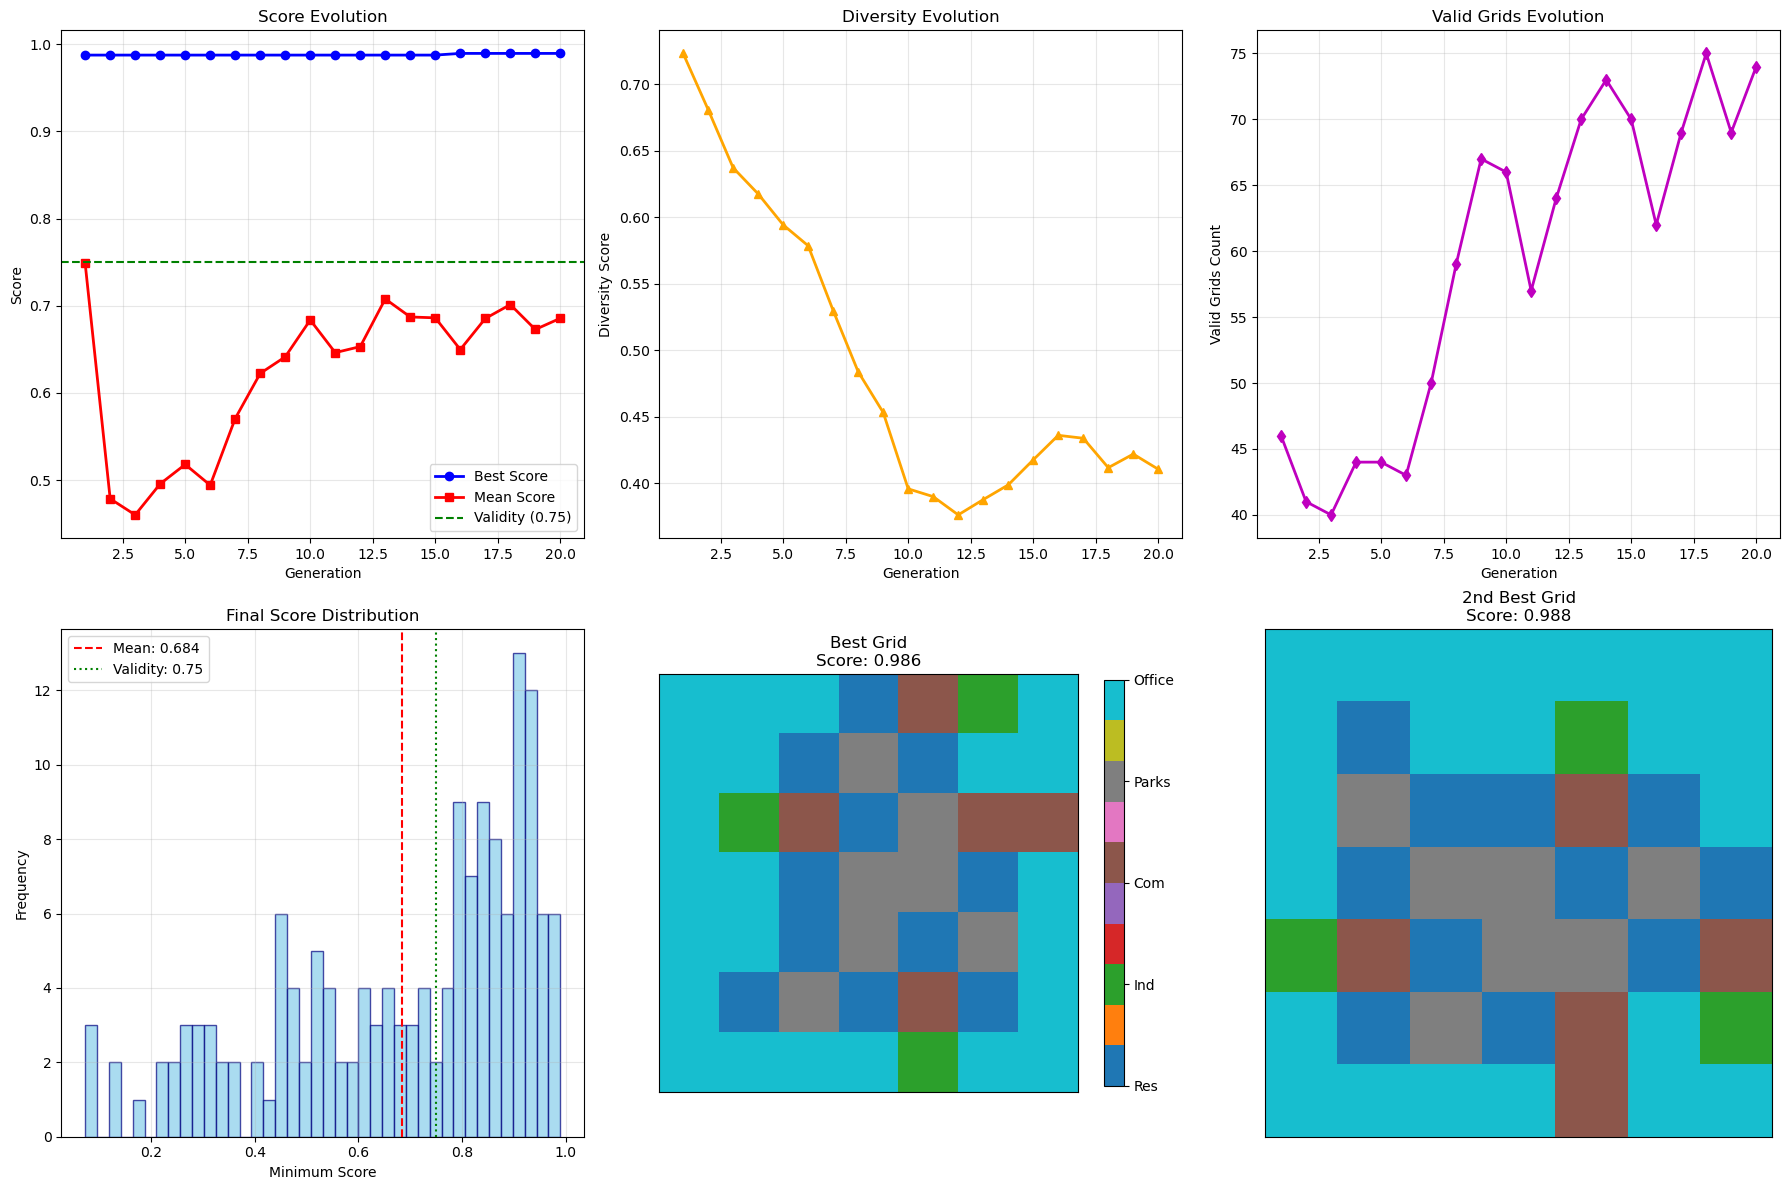


🏆 Visualizing Top 6 Generated Grids:


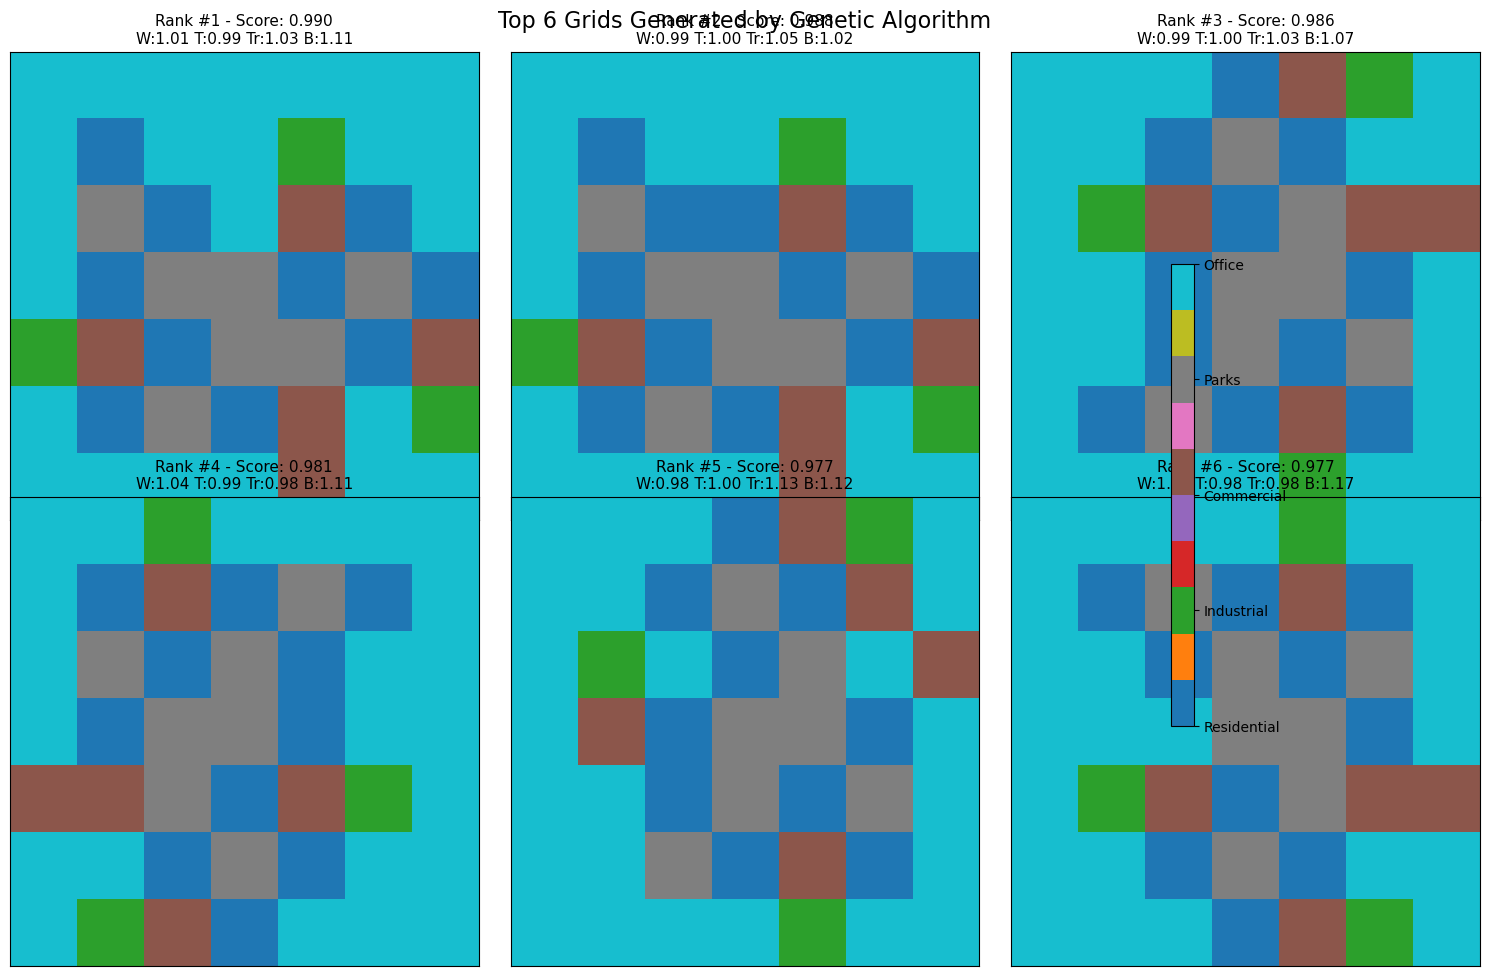


🧠 ADVISOR-SPECIFIC PERFORMANCE:
   Wellness:
     Mean: 0.7859
     Best: 1.1593
     ≥0.80: 98 grids
   Tax:
     Mean: 0.8659
     Best: 1.0150
     ≥0.80: 123 grids
   Transportation:
     Mean: 0.8927
     Best: 1.2803
     ≥0.80: 118 grids
   Business:
     Mean: 0.9590
     Best: 1.2407
     ≥0.80: 132 grids

💾 SAVING GENETIC ALGORITHM RESULTS:
✅ Saved genetic algorithm results:
   genetic_generated_grids_20251028_025412.npy ((154, 7, 7))
   genetic_predictions_20251028_025412.npy ((154, 4))
   genetic_best_grids_20251028_025412.npy ((100, 7, 7))
   genetic_algorithm_results_20251028_025412.json

🎉 GENETIC ALGORITHM GRID GENERATION COMPLETE!
✨ Key Achievements:
   • Generated 154 diverse, high-quality grids
   • Best score: 0.9896
   • 81 valid grids
   • Average diversity: 0.511
   • Used CNN Oracle models for accurate evaluation
   • Ready for submission building!


In [66]:
# 📊 ANALYSIS AND VISUALIZATION OF GENETIC ALGORITHM RESULTS
print("📊 Analysis and Visualization of Genetic Algorithm Results")
print("=" * 60)

if all_generated_grids is not None:
    print(f"📈 GENETIC ALGORITHM SUCCESS ANALYSIS:")
    print(f"   Total generated grids: {len(all_generated_grids)}")
    print(f"   Best score: {np.max(generated_min_scores):.4f}")
    print(f"   Mean score: {np.mean(generated_min_scores):.4f}")
    print(f"   Score std: {np.std(generated_min_scores):.4f}")
    
    # Compare with original dataset
    if 'min_scores' in locals():
        original_valid = np.sum(min_scores >= 0.75)
        generated_valid = np.sum(generated_min_scores >= 0.75)
        
        print(f"\n📊 COMPARISON WITH ORIGINAL DATASET:")
        print(f"   Original valid grids: {original_valid} ({original_valid/len(min_scores)*100:.2f}%)")
        print(f"   Generated valid grids: {generated_valid} ({generated_valid/len(generated_min_scores)*100:.2f}%)")
        print(f"   Improvement factor: {generated_valid/len(generated_min_scores) / (original_valid/len(min_scores)):.2f}x")
    
    # Score distribution analysis
    score_thresholds = [0.70, 0.75, 0.80, 0.85, 0.90]
    print(f"\n🎯 SCORE DISTRIBUTION:")
    for threshold in score_thresholds:
        count = np.sum(generated_min_scores >= threshold)
        percentage = count / len(generated_min_scores) * 100
        print(f"   ≥{threshold}: {count} grids ({percentage:.1f}%)")
    
    # Diversity analysis
    print(f"\n🌈 DIVERSITY ANALYSIS:")
    diversity_scores = []
    sample_size = min(100, len(all_generated_grids))  # Sample for speed
    sample_indices = np.random.choice(len(all_generated_grids), sample_size, replace=False)
    
    for i in range(sample_size):
        for j in range(i + 1, sample_size):
            grid1 = all_generated_grids[sample_indices[i]]
            grid2 = all_generated_grids[sample_indices[j]]
            diff_positions = np.sum(grid1 != grid2)
            diversity = diff_positions / 49.0
            diversity_scores.append(diversity)
    
    avg_diversity = np.mean(diversity_scores)
    print(f"   Average pairwise diversity: {avg_diversity:.3f}")
    print(f"   Diversity std: {np.std(diversity_scores):.3f}")
    print(f"   Min diversity: {np.min(diversity_scores):.3f}")
    print(f"   Max diversity: {np.max(diversity_scores):.3f}")
    
    # Evolution progress visualization
    if 'generation_stats' in locals():
        print(f"\n📈 Creating evolution progress visualization...")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Plot 1: Score evolution
        generations = [stat['generation'] for stat in generation_stats]
        best_scores = [stat['best_score'] for stat in generation_stats]
        mean_scores = [stat['mean_score'] for stat in generation_stats]
        
        axes[0, 0].plot(generations, best_scores, 'b-o', label='Best Score', linewidth=2)
        axes[0, 0].plot(generations, mean_scores, 'r-s', label='Mean Score', linewidth=2)
        axes[0, 0].axhline(y=0.75, color='green', linestyle='--', label='Validity (0.75)')
        axes[0, 0].set_xlabel('Generation')
        axes[0, 0].set_ylabel('Score')
        axes[0, 0].set_title('Score Evolution')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Diversity evolution
        diversity_scores = [stat['diversity'] for stat in generation_stats]
        axes[0, 1].plot(generations, diversity_scores, 'g-^', linewidth=2, color='orange')
        axes[0, 1].set_xlabel('Generation')
        axes[0, 1].set_ylabel('Diversity Score')
        axes[0, 1].set_title('Diversity Evolution')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: Valid grids count
        valid_counts = [stat['valid_count'] for stat in generation_stats]
        axes[0, 2].plot(generations, valid_counts, 'm-d', linewidth=2)
        axes[0, 2].set_xlabel('Generation')
        axes[0, 2].set_ylabel('Valid Grids Count')
        axes[0, 2].set_title('Valid Grids Evolution')
        axes[0, 2].grid(True, alpha=0.3)
        
        # Plot 4: Final score distribution
        axes[1, 0].hist(generated_min_scores, bins=40, alpha=0.7, color='skyblue', edgecolor='navy')
        axes[1, 0].axvline(np.mean(generated_min_scores), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(generated_min_scores):.3f}')
        axes[1, 0].axvline(0.75, color='green', linestyle=':', label='Validity: 0.75')
        axes[1, 0].set_xlabel('Minimum Score')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Final Score Distribution')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 5: Top grids visualization in axes[1, 1] and axes[1, 2]
        top_indices = np.argsort(generated_min_scores)[-3:]  # Top 3 grids
        
        # Show top 3 grids in axes[1, 1]
        axes[1, 1].axis('off')  # Turn off the main axis
        for i, idx in enumerate(top_indices):
            # Create small subplots within axes[1, 1]
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            
            # Use axes[1, 1] for the first grid
            if i == 0:
                im = axes[1, 1].imshow(grid, cmap='tab10', vmin=0, vmax=4)
                axes[1, 1].set_title(f'Best Grid\nScore: {score:.3f}', fontsize=12)
                axes[1, 1].set_xticks([])
                axes[1, 1].set_yticks([])
                axes[1, 1].axis('on')
        
        # Show comparison grids in axes[1, 2]
        if len(top_indices) > 1:
            # Show second best grid
            idx = top_indices[1]
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            
            im2 = axes[1, 2].imshow(grid, cmap='tab10', vmin=0, vmax=4)
            axes[1, 2].set_title(f'2nd Best Grid\nScore: {score:.3f}', fontsize=12)
            axes[1, 2].set_xticks([])
            axes[1, 2].set_yticks([])
        else:
            axes[1, 2].axis('off')
        
        # Add colorbar using the first image
        cbar = plt.colorbar(im, ax=axes[1, 1], shrink=0.8)
        cbar.set_ticks([0, 1, 2, 3, 4])
        cbar.set_ticklabels(['Res', 'Ind', 'Com', 'Parks', 'Office'])
        
        plt.tight_layout()
        plt.show()
        
        # Additional visualization: Top 6 grids in a separate figure
        print(f"\n🏆 Visualizing Top 6 Generated Grids:")
        top_6_indices = np.argsort(generated_min_scores)[-6:][::-1]  # Top 6, best first
        
        fig_grids, axes_grids = plt.subplots(2, 3, figsize=(15, 10))
        axes_grids = axes_grids.flatten()
        
        for i, idx in enumerate(top_6_indices):
            grid = all_generated_grids[idx]
            score = generated_min_scores[idx]
            predictions = generated_predictions[idx]
            
            im = axes_grids[i].imshow(grid, cmap='tab10', vmin=0, vmax=4)
            axes_grids[i].set_title(f'Rank #{i+1} - Score: {score:.3f}\n' + 
                                   f'W:{predictions[0]:.2f} T:{predictions[1]:.2f} '
                                   f'Tr:{predictions[2]:.2f} B:{predictions[3]:.2f}', 
                                   fontsize=11)
            axes_grids[i].set_xticks([])
            axes_grids[i].set_yticks([])
        
        # Add shared colorbar
        cbar_grids = plt.colorbar(im, ax=axes_grids, shrink=0.6, pad=0.1)
        cbar_grids.set_ticks([0, 1, 2, 3, 4])
        cbar_grids.set_ticklabels(['Residential', 'Industrial', 'Commercial', 'Parks', 'Office'])
        
        plt.suptitle('Top 6 Grids Generated by Genetic Algorithm', fontsize=16, y=0.98)
        plt.tight_layout()
        plt.show()
    
    # Advisor-specific analysis
    print(f"\n🧠 ADVISOR-SPECIFIC PERFORMANCE:")
    advisor_names = ["Wellness", "Tax", "Transportation", "Business"]
    for i, advisor in enumerate(advisor_names):
        advisor_scores = generated_predictions[:, i]
        print(f"   {advisor}:")
        print(f"     Mean: {np.mean(advisor_scores):.4f}")
        print(f"     Best: {np.max(advisor_scores):.4f}")
        print(f"     ≥0.80: {np.sum(advisor_scores >= 0.80)} grids")
    
    print(f"\n💾 SAVING GENETIC ALGORITHM RESULTS:")
    timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
    
    # Save results
    np.save(f'data/generated_grids/genetic_generated_grids_{timestamp}.npy', all_generated_grids)
    np.save(f'data/generated_grids/genetic_predictions_{timestamp}.npy', generated_predictions)
    np.save(f'data/generated_grids/genetic_best_grids_{timestamp}.npy', best_generated_grids)
    
    # Save metadata
    metadata = {
        'timestamp': timestamp,
        'method': 'genetic_algorithm',
        'population_size': 500,
        'generations': 20,
        'total_grids': len(all_generated_grids),
        'best_score': float(np.max(generated_min_scores)),
        'mean_score': float(np.mean(generated_min_scores)),
        'valid_grids': int(np.sum(generated_min_scores >= 0.75)),
        'diversity_score': float(avg_diversity),
        'oracle_models_used': list(loaded_models.keys()) if 'loaded_models' in locals() else []
    }
    
    import json
    with open(f'data/generated_grids/genetic_algorithm_results_{timestamp}.json', 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"✅ Saved genetic algorithm results:")
    print(f"   genetic_generated_grids_{timestamp}.npy ({all_generated_grids.shape})")
    print(f"   genetic_predictions_{timestamp}.npy ({generated_predictions.shape})")
    print(f"   genetic_best_grids_{timestamp}.npy ({best_generated_grids.shape})")
    print(f"   genetic_algorithm_results_{timestamp}.json")
    
    print(f"\n🎉 GENETIC ALGORITHM GRID GENERATION COMPLETE!")
    print(f"✨ Key Achievements:")
    print(f"   • Generated {len(all_generated_grids)} diverse, high-quality grids")
    print(f"   • Best score: {np.max(generated_min_scores):.4f}")
    print(f"   • {np.sum(generated_min_scores >= 0.75)} valid grids")
    print(f"   • Average diversity: {avg_diversity:.3f}")
    print(f"   • Used CNN Oracle models for accurate evaluation")
    print(f"   • Ready for submission building!")
    
else:
    print("❌ No results to analyze - genetic algorithm did not run successfully")